In [1]:
import tensorflow as tf

import numpy as np
from numpy import asarray
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt 
from matplotlib import image

import math as m
from PIL import Image
import random

import requests as req
import csv
import os
print(os.getcwd())
from sys import getsizeof

import copy

print(tf.__version__)


/Users/babi/Documents/GitHub/Quickdraw1/training_quickdraw
2.4.0


In [158]:
def download_npy(categories,number_of_samples):

    number_of_categories = len(categories)
    data = np.array([], dtype=np.int64).reshape(0,784)
    for i in range(number_of_categories):
        filename = categories[i][0] + '.npy'
        filename = filename.replace(" ","%20")
        
        url = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'+filename
        
        r = req.get(url, allow_redirects=True)
        #filename = os.path.basename(url)
        #filename = filename.replace("%20","")
        open(filename, 'wb').write(r.content)
        
        data = np.vstack([data,load_data(filename,number_of_samples)])
        
        os.remove(filename)
        print(i+1,'/',number_of_categories,' ',filename.replace("%20",""))
    return data

def load_data(name,n):
    filename = name
    label = name
    data = np.load(filename)
    #data = np.ndarray.reshape(data,len(data),28,28)
    return data[0:n,:]

#randomize data and labels
def shuff(data,label):
    
    s = np.shape(data)
    n = s[0]
    
    l = len(label)
    label_new = np.zeros(l)
    
    if len(2*s)==2:
        d = 1
        m = 1
        data_new = np.zeros((n,m))

    elif len(2*s)==4:
        d = 2
        m = s[1]
        data_new = np.zeros((n,m))
    
    orderid = random.sample(range(n), n) 
    
    for i in range(n):
        data_new[i] = data[orderid[i]]
        label_new[i] = int(label[orderid[i]])
        
    return data_new, label_new

def download_and_save(number_of_categories,number_of_samples):

    x = [random.randint(0, 345) for p in range(0, number_of_categories)]

    #load categories
    categories = open("categories.txt",'r')
    reader = csv.reader(categories)
    categories = [row for row in reader]
    categories = [categories[row] for row in x]
    
    d = download_npy(categories,number_of_samples)
    
    #save Data
    filename = 'dataset/data_{}_{}.csv'.format(number_of_categories,number_of_samples)
    np.savetxt(filename, d, delimiter=',')
    
    #save Categories
    filename = 'dataset/cat_{}_{}.csv'.format(number_of_categories,number_of_samples)
    with open(filename, 'w') as f: 
        write = csv.writer(f) 
        write.writerows(categories)
    return d, categories
    
def data_from_file(number_of_categories,number_of_samples):
    
    filename = 'dataset/data_{}_{}.csv'.format(number_of_categories,number_of_samples)
    d = np.loadtxt(filename, delimiter=',')
    filename = 'dataset/cat_{}_{}.csv'.format(number_of_categories,number_of_samples)
    categories = open(filename,'r')
    reader = csv.reader(categories)
    categories = [row for row in reader]
    
    return d, categories

def predict_image(path_image):
    image = Image.open(path_image)
    image_resize = image.resize((28,28))
    image_small= asarray(image_resize)
    image_small = abs(image_small-255.)/255.
    image_small = image_small[:, :, 0]
    #image_small = np.expand_dims(image_small, axis=0)
    
    data4 = np.reshape(image_small,(28,28,1))
    data4 = np.expand_dims(data4, axis=0)
    
    predictions = model.predict(data4)
    print(cats[np.argmax(predictions)])
    plt.imshow(image_small)
    plt.show()

In [3]:
def define_model(number_of_categories):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(16, (5, 5), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(tf.keras.layers.Dense(number_of_categories, activation='softmax'))
    
    # compile model
    opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [148]:
ncat = 10
nsam = 5000

##load data
d, cats = download_and_save(ncat,nsam)
#d, cats = data_from_file(ncat,nsam)

cat_id = np.repeat(range(ncat),nsam)

print('Categories: ', cats)
print(np.shape(d),' ',np.shape(cat_id))


1 / 10   donut.npy
2 / 10   mouth.npy
3 / 10   snail.npy
4 / 10   microphone.npy
5 / 10   drill.npy
6 / 10   crown.npy
7 / 10   swan.npy
8 / 10   mug.npy
9 / 10   snowman.npy
10 / 10   stereo.npy
Categories:  [['donut'], ['mouth'], ['snail'], ['microphone'], ['drill'], ['crown'], ['swan'], ['mug'], ['snowman'], ['stereo']]
(50000, 784)   (50000,)


In [149]:
#Shuffle data
data,cat_id = shuff(d,cat_id)
data_rs = np.reshape(data,(len(data),28,28))

#data to 4D
data4 = np.reshape(data,(len(data),28,28,1))

#split data
training = 0.8
test = 1.-training

x_train = data4[0:m.floor(training*len(data4))]/ 255.0
y_train = cat_id[0:m.floor(training*len(cat_id))]

x_test = data4[m.ceil(training*len(data4)):len(data4),:]/ 255.0
y_test = cat_id[m.ceil(training*len(cat_id)):len(cat_id)]

print('Train-Set: ','Samples',np.shape(x_train)[0],'/ Labels', np.shape(y_train)[0])
print('Test-Set: ','Samples',np.shape(x_test)[0],'/ Labels', np.shape(y_test)[0])

Train-Set:  Samples 40000 / Labels 40000
Test-Set:  Samples 10000 / Labels 10000


['mug'] 34930


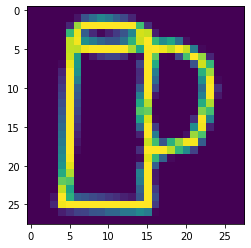

In [151]:
#TEST Show
i=random.randint(1,len(data_rs))
plt.imshow(data_rs[i])
print(cats[int(cat_id[i])],i)

In [153]:
#Model and Train
model = define_model(ncat)
history = model.fit(x_train, y_train,batch_size = 32, epochs=5)

_, acc = model.evaluate(x_test,  y_test, verbose=2);

print('Accuracy > %.3f' % (acc * 100.0))

# stores scores
scores, histories = list(), list()
scores.append(acc)
histories.append(history)

Epoch 1/5
1250/1250 [==============================] - 21s 17ms/step - loss: 0.8746 - accuracy: 0.7274
Epoch 2/5
1250/1250 [==============================] - 21s 17ms/step - loss: 0.3337 - accuracy: 0.9031
Epoch 3/5
1250/1250 [==============================] - 21s 17ms/step - loss: 0.2791 - accuracy: 0.9183
Epoch 4/5
1250/1250 [==============================] - 21s 17ms/step - loss: 0.2452 - accuracy: 0.9248
Epoch 5/5
1250/1250 [==============================] - 21s 17ms/step - loss: 0.2249 - accuracy: 0.9326
313/313 - 1s - loss: 0.3130 - accuracy: 0.9129
Accuracy > 91.290


In [154]:
#Test Predictions
predictions = model.predict(x_test)

['mouth']


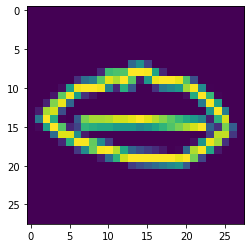

In [155]:
i=random.randint(1,len(x_test))
x_test_0 = np.reshape(x_test[i],(28,28))
plt.imshow(x_test_0)
print(cats[np.argmax(predictions[i])])

['crown']


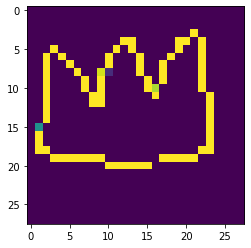

In [159]:
#predict 
predict_image('dataset/crown.png')

['key'] 3


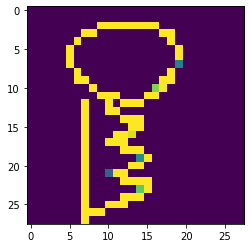

In [137]:
image = Image.open('dataset/key2.png')
data_resize = image.resize((28,28))
data_resize = asarray(data_resize)
data_resize = data_resize[:,:,0]
data_resize = abs(data_resize - 255.0)/255.0

data4 = np.reshape(data_resize,(28,28,1))
data4 = np.expand_dims(data4, axis=0)

plt.imshow(data_resize)
p = model.predict(data4)
print(cats[np.argmax(p)], np.argmax(p))


dict_keys(['loss', 'accuracy'])


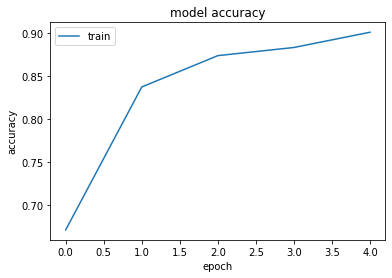

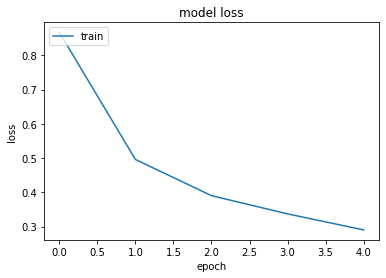

In [130]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [159]:
name = "qd_cnn_sgd_50_10000.h5"
saved_model_dir = 'save/'+str(name)
model.save(saved_model_dir)
print('Model Saved to '+saved_model_dir)

Model Saved to save/qd_cnn_sgd_50_10000.h5
